# SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la carga de los módulos necesarios:

In [2]:
import pandas as pd
import numpy as np
# ! pip install lightgbm
import lightgbm as lgb
import random
random.seed(7)

Cargamos con **pandas** lentamente el dataset. Sólo vamos a trabajar con el primer conjunto de datos que es el más pequeño. Con un poco más de paciencia podrá usar los conjuntos más pesados. 

In [5]:
df_train = pd.read_csv("../../../datasets/competencia2_2022.csv.gz")

Xtrain = df_train[df_train["foto_mes"] < 202104]
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

/home/santiago/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3135: DtypeWarning: Columns (154) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Separamos también todos los casos de **BAJAS+1** y **BAJAS+2**

In [6]:
Xbajas = df_train.query("foto_mes == 202101 and clase_ternaria != 'CONTINUA'")

Y nos deshacemos del target y limpiamos un poco la memoria.

In [7]:
Xtrain = Xtrain.drop("clase_ternaria", axis=1)
Xbajas = Xbajas.drop("clase_ternaria", axis=1)

del(df_train)

Hacemos un modelo **LGBM**

In [8]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(Xtrain, ytrain)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.05,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 4000,
    'verbose': 0,
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100)


lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


,Features,Importances
8,mrentabilidad_annual,194
10,mactivos_margen,110
22,mcuentas_saldo,110
33,mprestamos_personales,104
72,mcomisiones_mantenimiento,84
...,...,...
78,cforex_sell,0
76,cforex_buy,0
75,cforex,0
19,mcaja_ahorro_adicional,0


Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [9]:
#! pip install shap
import shap

In [10]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(Xbajas)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Consolidamos los valores de **SHAP** para cada variable y para cada **BAJA+\***

In [11]:
shap_bajas = pd.DataFrame(shap_values[0], columns = Xbajas.columns)
shap_bajas

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo
0,-0.003793,0.043978,1.183228e-05,0.0,-0.004454,0.012084,-0.008685,-0.057202,0.190892,-0.011000,...,0.0,-0.000499,-0.029357,-0.016039,0.000444,-0.022537,0.0,0.021027,0.0,-0.081141
1,-0.003260,0.085797,-2.042664e-03,0.0,-0.010508,0.017828,-0.005686,0.020467,-0.141381,-0.005187,...,0.0,0.001769,0.001965,-0.007802,-0.003009,-0.016234,0.0,-0.054170,0.0,-0.056592
2,-0.010338,0.055827,2.858319e-05,0.0,-0.001304,-0.148143,0.006311,0.000246,0.036989,-0.004084,...,0.0,-0.001472,-0.002234,0.023429,0.000860,-0.018684,0.0,0.023555,0.0,0.041125
3,-0.005776,0.020735,3.207840e-04,0.0,-0.005487,-0.079864,-0.000071,-0.003782,0.021049,-0.010975,...,0.0,-0.000344,0.003401,0.001057,0.000448,-0.067191,0.0,0.042811,0.0,-0.073921
4,0.015626,0.040803,-1.525316e-05,0.0,-0.008573,-0.118198,-0.012186,-0.044332,0.214057,-0.013775,...,0.0,-0.002192,-0.027716,-0.030530,0.000444,-0.047591,0.0,0.021237,0.0,-0.133835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509,0.077619,0.061417,1.111178e-07,0.0,-0.003720,0.017214,0.008444,0.012172,-0.105342,0.001607,...,0.0,-0.002088,0.001347,-0.015496,0.000674,0.087642,0.0,0.047899,0.0,0.113486
1510,0.020752,0.024899,2.341423e-03,0.0,-0.004945,0.023249,0.024243,0.005838,-0.106612,0.002220,...,0.0,-0.002771,0.002473,-0.004575,-0.004564,0.104884,0.0,-0.003475,0.0,-0.120493
1511,0.028173,0.038494,-3.638090e-04,0.0,-0.007298,0.028520,0.015856,0.018431,-0.111809,0.002961,...,0.0,-0.003332,0.002472,-0.005704,-0.004564,0.088955,0.0,-0.008264,0.0,-0.149351
1512,0.014725,0.030933,1.674283e-03,0.0,-0.007341,-0.110784,0.036641,-0.017086,-0.152533,-0.011938,...,0.0,-0.002471,0.002071,-0.005867,-0.004564,0.082940,0.0,-0.002158,0.0,-0.105490


Y consolidamos sus importancias

In [12]:
shap_importancias = shap_bajas.mean().abs().sort_values(ascending=False)
shap_importancias

ctrx_quarter             0.937456
cpayroll_trx             0.409204
mpayroll                 0.359552
mtarjeta_visa_consumo    0.198276
mprestamos_personales    0.185207
                           ...   
cseguro_auto             0.000000
cforex                   0.000000
cinversion2              0.000000
minversion1_dolares      0.000000
mforex_buy               0.000000
Length: 154, dtype: float64

La librería nos da útiles herramientas para vizualizar la info anterior

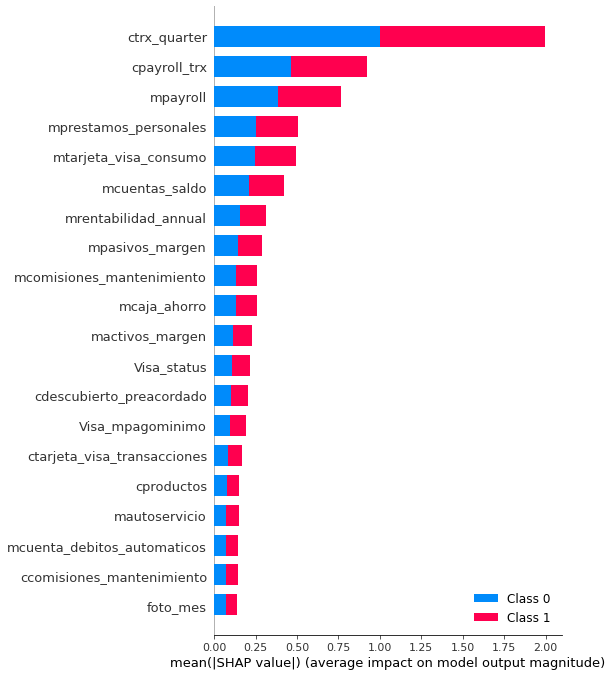

In [13]:
shap.summary_plot(shap_values, Xbajas)


Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

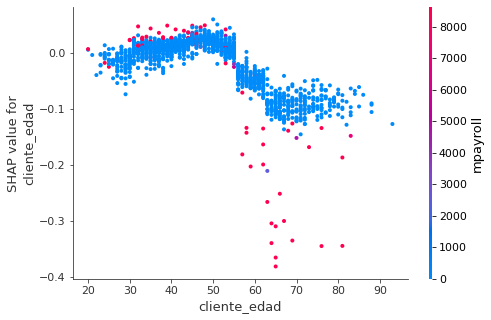

In [14]:
shap.dependence_plot("cliente_edad", shap_values[0], Xbajas)

¿Se podrá hacer una clusterización sobre los valores de shap? 

Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Como la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento.

In [15]:
from umap import UMAP
import matplotlib.pyplot as plt


2022-10-27 16:32:52.367142: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/santiago/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-10-27 16:32:52.367165: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

KeyboardInterrupt



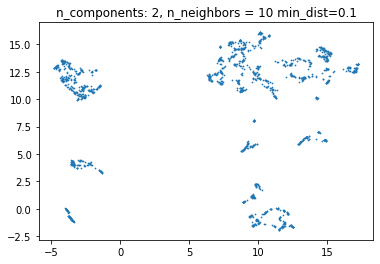

Error in callback <function flush_figures at 0x7fe896bd9550> (for post_execute):


KeyboardInterrupt: 

In [18]:
for n_comp in range(2,10):
    for n_nei in [10,40,100]:
        for min_dist in np.linspace(0.1,0.8,7):
            embedding_2d = UMAP(n_components=n_comp,
                                n_neighbors=n_nei,
                               min_dist=min_dist).fit_transform(shap_values[0])
            plt.figure()
            plt.scatter(embedding_2d[:,0], embedding_2d[:,1], s = .5)
            plt.title(f"n_components: {n_comp}, n_neighbors = {n_nei} min_dist={min_dist}")

Text(0.5, 1.0, 'n_components: 8, n_neighbors = 40')

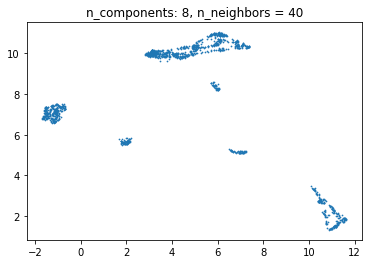

In [19]:
# Elijo una combinación que me haya gustado.
n_comp, n_nei, min_dist = 8, 40, 0.25

embedding_2d = UMAP(n_components=n_comp, n_neighbors=n_nei).fit_transform(shap_values[0])
plt.figure()
plt.scatter(embedding_2d[:,0], embedding_2d[:,1], s = 0.5)
plt.title(f"n_components: {n_comp}, n_neighbors = {n_nei}")

In [20]:
#! pip install hdbscan
import hdbscan

In [21]:
labels = hdbscan.HDBSCAN(
    min_samples=20,
    min_cluster_size=20,
).fit_predict(embedding_2d)

In [22]:
labels[[i in [-1,4,6,7,8,9,10,11,12,13] for i in labels]] = 4

# Ojo, acá estoy dejando muestras sin clasificar.
clustered = (labels >= 0)


In [23]:
labels += 1

## Su momento de brillar: Qué se puede hacer desde este punto para tratar de interpretar los distintos segmentos para la presentación de Miranda.

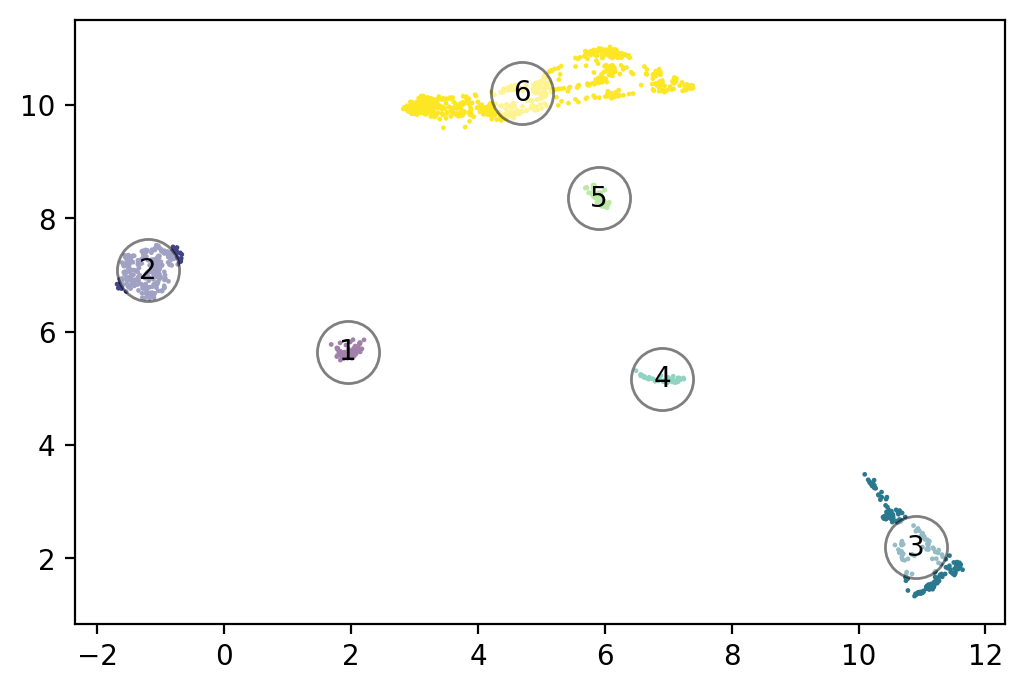

In [24]:
plt.figure(dpi = 200)
plt.scatter(embedding_2d[clustered, 0], embedding_2d[clustered, 1], c=labels[clustered], s=0.5, cmap='viridis');
# Si hay muestras sin clasificar, van en negro.
plt.scatter(embedding_2d[~clustered, 0], embedding_2d[~clustered, 1], c="black", s=.1)

shapx = embedding_2d[:, 0]
shapy = embedding_2d[:, 1]
label = labels
# Así vemos la media de cada grupo en los dos ejes.
shap_centroids = pd.DataFrame({"shapx":shapx,
             "shapy":shapy,
             "label":label }).groupby("label").mean()

for i,row in shap_centroids.iterrows():
    plt.scatter(row.shapx, row.shapy, s = 500, facecolors='white', edgecolors='k', alpha = .5)
    plt.text(row.shapx, row.shapy, s = str(i), va = "center", ha = "center", fontsize = 10)

In [25]:
Xbajas["cluster"] = labels

In [26]:
top_cols = list(lgbm_importancia.Features.head(10))

47.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
52.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


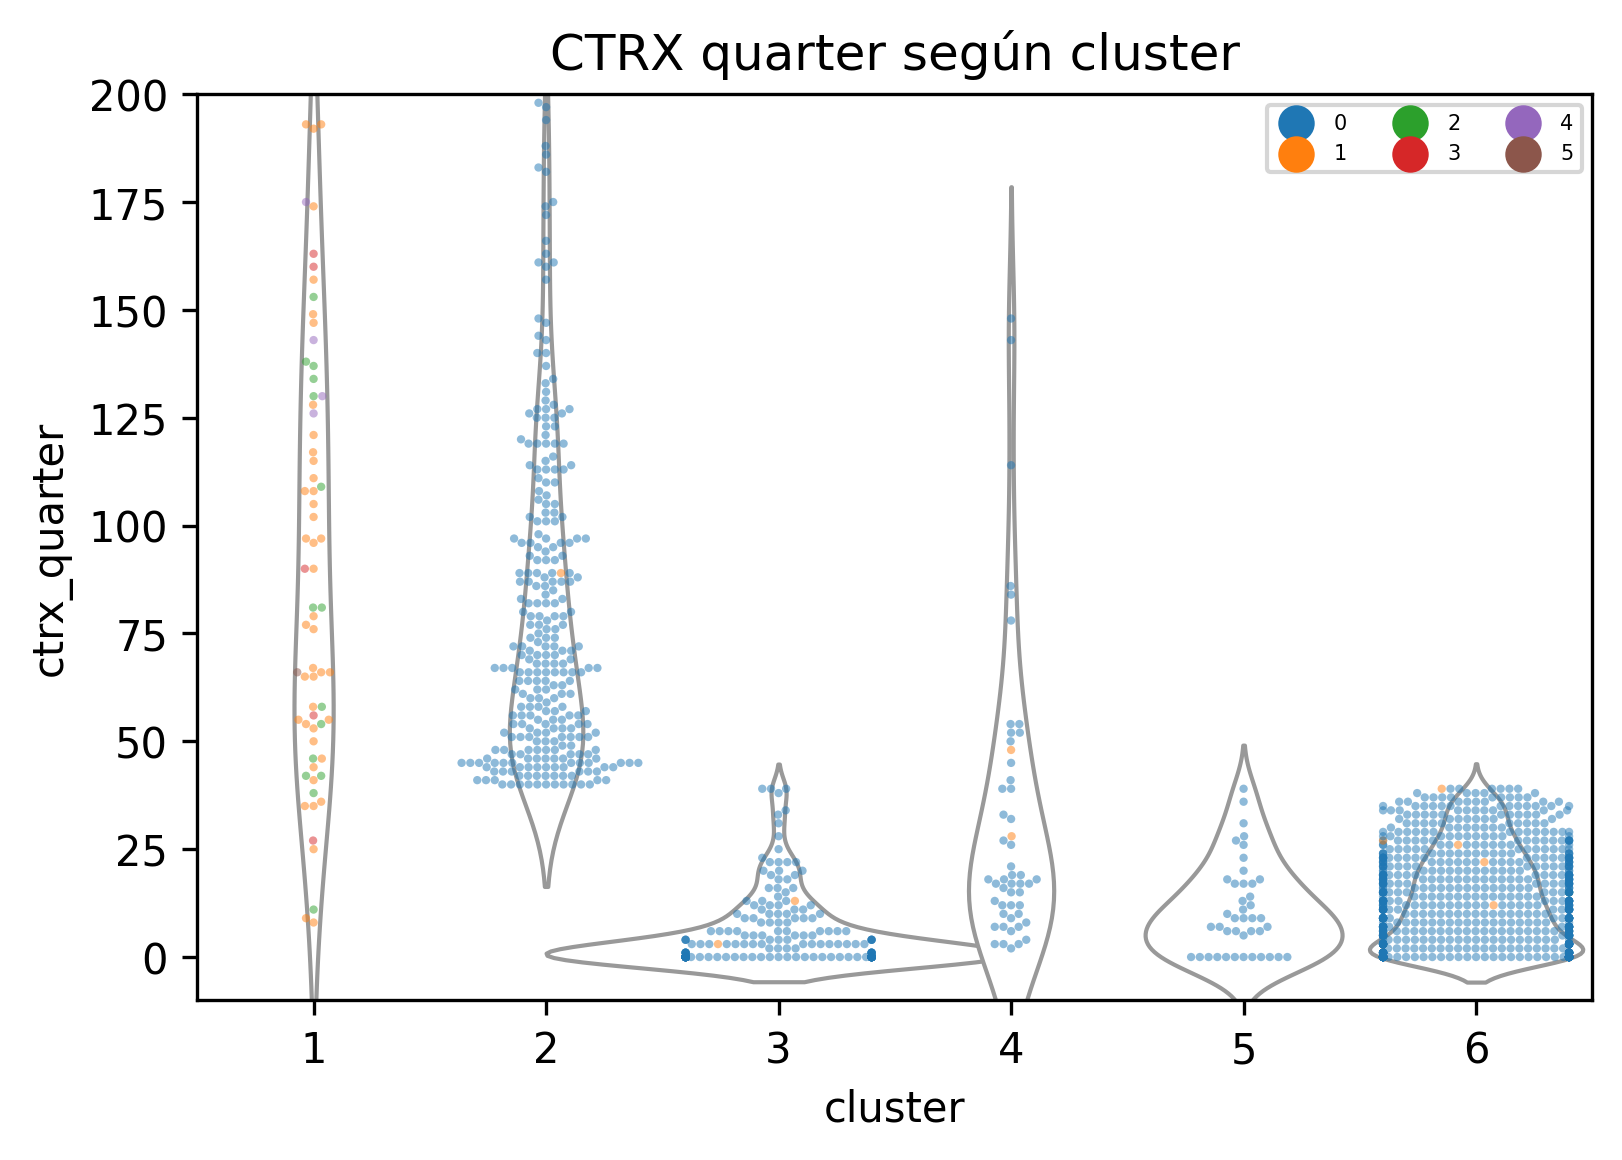

In [27]:
import seaborn as sns
plt.figure(dpi = 300)

sns.swarmplot(y="ctrx_quarter", 
                x="cluster", 
                data=Xbajas[Xbajas.ctrx_quarter < 200], 
                   hue="cpayroll_trx", palette = "tab10", s = 2, alpha = 0.5)

sns.violinplot(data = Xbajas[Xbajas.ctrx_quarter < 200],
            y = "ctrx_quarter", 
            x = "cluster", 
            saturation = 1,
            color = "white",
           linewidth = 1, width=2, inner= None)

plt.ylim(-10,200)
plt.title("CTRX quarter según cluster")
plt.legend(ncol = 3, fontsize = 5);

In [28]:
def coloured_table(columna, cols = ["25%","50%","75%"], verbose = True, fillna = True):
    if fillna: 
        Xb = Xbajas.fillna(0);  Xt= Xtrain.fillna(0)
    else:
        Xb = Xbajas
        Xt = Xtrain
    bajas = Xb[["cluster",columna]].groupby("cluster").describe()
    conts = Xt[ytrain == 0][[columna]].describe().transpose()
    bajas.index = [f"BAJA_{i}" for i in bajas.index]
    conts.index = ["CONTINUA"]

    bajas.columns = conts.columns
    if verbose: print(columna)
    return bajas.append(conts)[cols].style\
    .background_gradient(cmap='ocean', axis=None)\
    .highlight_null(null_color='#f1f1f1')\
    .set_precision(2)

In [29]:
coloured_table("ctrx_quarter", ["count"], verbose = False)

,count
BAJA_1,75.00
BAJA_2,291.00
BAJA_3,214.00
BAJA_4,51.00
BAJA_5,42.00
BAJA_6,841.00
CONTINUA,480796.00


In [30]:
coloured_table("mcuentas_saldo")

mcuentas_saldo


,25%,50%,75%
BAJA_1,2997.75,26532.26,94889.01
BAJA_2,-910.42,4649.23,40690.50
BAJA_3,-11956.17,-2333.52,18.70
BAJA_4,-3022.02,-75.33,1078.95
BAJA_5,-9167.37,-2101.06,831.75
BAJA_6,-5069.55,-1017.51,617.71
CONTINUA,959.45,35371.90,139751.95


Se aprecia claramente como hay marcadas diferencias en los clusters. Si bien el promedio de mcuentas_saldo (**saldo total de todas las cuentas del cliente en pesos**) es en todos los baja inferior, hay varios clusters de usuarios baja con saldo elevado en cuenta: cluster 2, 5 y 6. Por el otro lado, están los clusters 1,3 y 4 donde están representados usuarios con bajo saldo en cuenta, incluso con la mayoría de ellos en negativo.

In [31]:
coloured_table("ctrx_quarter")

ctrx_quarter


,25%,50%,75%
BAJA_1,54.50,96.00,140.50
BAJA_2,50.00,70.00,102.00
BAJA_3,0.00,1.00,6.00
BAJA_4,11.00,18.00,43.00
BAJA_5,0.00,9.00,17.00
BAJA_6,3.00,11.00,21.00
CONTINUA,60.00,106.00,159.00


La variable ctrx_quarter representa la **cantidad de movimientos en las cuentas bancarias de los últimos tres meses**. Vemos que nuevamente, los usuarios de los clusters 2 y 6 tienen el comportamiento más similar a los continua, mientras que los de los clusters 1,3,4 tienen valores bajos de movimientos. El cluster 5 tenía un comportamiento intermedio en la variable anterior y repite en esta.

In [32]:
coloured_table("Visa_mconsumototal")

Visa_mconsumototal


,25%,50%,75%
BAJA_1,0.00,1173.53,10282.61
BAJA_2,0.00,3002.88,12263.63
BAJA_3,0.00,0.00,0.00
BAJA_4,0.00,0.00,2328.78
BAJA_5,0.00,0.00,0.00
BAJA_6,0.00,0.00,462.16
CONTINUA,510.20,6897.35,22295.53


Se complica separar a los grupos, voy a entrenar otro modelo para predecir cluster

In [33]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(Xbajas.drop(columns = "cluster"),  Xbajas.cluster -1)

# specify your configurations as a dict
params = {
    'objective': 'multiclass',
    'learning_rate': 0.05,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 50,
    'verbose': 0,
    "num_class":6
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100)





[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [34]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia.head(20)

,Features,Importances
107,ctrx_quarter,2470
18,mcaja_ahorro,1235
33,mprestamos_personales,816
21,cdescubierto_preacordado,702
8,mrentabilidad_annual,549
11,mpasivos_margen,535
127,Master_fechaalta,451
147,Visa_mpagospesos,441
81,mtransferencias_recibidas,403
22,mcuentas_saldo,366


In [35]:
coloured_table("mpasivos_margen")

mpasivos_margen


,25%,50%,75%
BAJA_1,256.80,601.36,1474.50
BAJA_2,91.80,292.64,707.16
BAJA_3,0.00,2.21,32.80
BAJA_4,23.71,136.88,463.25
BAJA_5,2.43,14.38,116.11
BAJA_6,0.00,9.13,73.92
CONTINUA,241.51,670.32,1566.09


In [36]:
coloured_table("mcuenta_corriente")

mcuenta_corriente


,25%,50%,75%
BAJA_1,-379.35,0.00,0.00
BAJA_2,-894.09,-29.60,0.00
BAJA_3,-12097.72,-1468.26,0.00
BAJA_4,-2928.11,-449.10,0.00
BAJA_5,-6935.80,-1778.59,-12.77
BAJA_6,-4101.35,-528.98,0.00
CONTINUA,-781.36,0.00,0.00


In [37]:
coloured_table("Visa_mpagominimo", fillna=False)

Visa_mpagominimo


,25%,50%,75%
BAJA_1,11.73,1032.24,3542.46
BAJA_2,149.56,1049.84,3744.80
BAJA_3,0.00,0.00,43.99
BAJA_4,0.00,0.00,598.23
BAJA_5,0.00,0.00,11.73
BAJA_6,0.00,0.00,199.41
CONTINUA,539.58,2205.24,5747.70


El cluster 1 es particular: no tiene acuerdo de descubierto.

In [38]:
coloured_table("cdescubierto_preacordado", fillna=False)

cdescubierto_preacordado


,25%,50%,75%
BAJA_1,1.00,1.00,1.00
BAJA_2,1.00,1.00,1.00
BAJA_3,0.00,0.00,0.00
BAJA_4,0.50,1.00,1.00
BAJA_5,0.00,1.00,1.00
BAJA_6,1.00,1.00,1.00
CONTINUA,1.00,1.00,1.00


In [40]:
Xbajas.groupby("cluster").quantile(.25)[["cdescubierto_preacordado"]]

,cdescubierto_preacordado
cluster,
1,1.0
2,1.0
3,0.0
4,0.5
5,0.0
6,1.0
